## Two stage Classification (STACKED MODELS) and RESULTS

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
#import matplotlib.pyplot as plt
from imutils import paths 
import os
import random
#import matplotlib.image as mpimg
#%matplotlib inline
from tqdm import tqdm
#from matplotlib import patches
from sklearn.externals import joblib 
import numpy as np
import os 
from keras.applications import VGG16 #importing Keras implementation of the pre-trained VGG16 network
from keras.applications import imagenet_utils #Utilities for ImageNet data preprocessing & prediction decoding
from keras.preprocessing.image import img_to_array,load_img #importing functions to load image and covert to array
from keras.layers import Input
import random
from tqdm import tqdm
from keras.models import Model
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from keras.layers.core import Dense,Dropout,Flatten
from imutils import paths #it will create a list of paths for each image 
from sklearn.preprocessing import LabelBinarizer #it will encode categories into numerical value
from sklearn.model_selection import train_test_split #library for train_test split of data 

C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
from object_detection.utils import label_map_util
import tensorflow as tf
import numpy as np
import imutils
import cv2
from PIL import Image
#import matplotlib.pyplot as plt

In [3]:
train=pd.read_json ('training.json')

In [4]:
from tqdm import tqdm
data=[]
for i in tqdm(range(train.shape[0])):
    for j in range(len(train.iloc[i,1])):
        img_name=train.iloc[i,0]['pathname'].split('/')[2]
        label=train.iloc[i,1][j]['category']
        x_min=train.iloc[i,1][j]['bounding_box']['minimum']['c']
        x_max=train.iloc[i,1][j]['bounding_box']['maximum']['c']
        y_min=train.iloc[i,1][j]['bounding_box']['minimum']['r']
        y_max=train.iloc[i,1][j]['bounding_box']['maximum']['r']
        
        data.append([img_name,label,x_min,y_min,x_max,y_max])
        

100%|█████████████████████████████████████████████████████████████████████████████| 1208/1208 [00:08<00:00, 146.09it/s]


In [5]:
df_train=pd.DataFrame(data,columns=['img_name','label','x_min','y_min','x_max','y_max'])

In [6]:
df_train.label.value_counts()

red blood cell    77420
trophozoite        1473
difficult           441
ring                353
schizont            179
gametocyte          144
leukocyte           103
Name: label, dtype: int64

In [7]:
non_rbc=['trophozoite', 'schizont', 'ring','gametocyte','leukocyte']

In [8]:
# converting all cells other than rbc to non-rbc
for i in tqdm(range(80113)):
    if df_train.iloc[i,1] in non_rbc:
        df_train.iloc[i,1]='non_rbc'

100%|██████████████████████████████████████████████████████████████████████████| 80113/80113 [00:23<00:00, 3443.73it/s]


In [9]:
df_train.img_name=df_train.img_name.apply(lambda x: "training_images/"+str(x))

In [10]:
df_train_two=df_train[df_train['label']!="difficult"]

In [11]:
from tqdm import tqdm
data=[]
for i in tqdm(range(train.shape[0])):
    for j in range(len(train.iloc[i,1])):
        img_name=train.iloc[i,0]['pathname'].split('/')[2]
        label=train.iloc[i,1][j]['category']
        x_min=train.iloc[i,1][j]['bounding_box']['minimum']['c']
        x_max=train.iloc[i,1][j]['bounding_box']['maximum']['c']
        y_min=train.iloc[i,1][j]['bounding_box']['minimum']['r']
        y_max=train.iloc[i,1][j]['bounding_box']['maximum']['r']
        
        data.append([img_name,label,x_min,y_min,x_max,y_max])
        

100%|█████████████████████████████████████████████████████████████████████████████| 1208/1208 [00:06<00:00, 172.83it/s]


In [12]:
df_train=pd.DataFrame(data,columns=['img_name','label','x_min','y_min','x_max','y_max'])

In [13]:
df_train.img_name=df_train.img_name.apply(lambda x: "training_images/"+str(x))

In [14]:
df_train_all=df_train[df_train['label']!="difficult"]

In [15]:
df_train_two.label.value_counts()

red blood cell    77420
non_rbc            2252
Name: label, dtype: int64

In [16]:
df_train_all.label.value_counts()

red blood cell    77420
trophozoite        1473
ring                353
schizont            179
gametocyte          144
leukocyte           103
Name: label, dtype: int64

In [17]:
#laoding trained model and classes for faster-rcnn ||already trained and saved on disk

model="C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/exported_model/frozen_inference_graph.pb" #saved Faster-RCNN model graph
labels_loc="C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/records/classes.pbtxt" #saved classes files
min_confidence=0.5
num_classes=2

In [18]:
colors=np.float64(np.array([[255,1,1],
       [86, 1,255],
       [1,231,255],
       [1,255,61],
       [214,255,1],
       [255,120,1]]))

## Prediction on Training Data using Fine-tuned VGG-16

In [19]:
training_images=np.unique(df_train_all.img_name.values)
print(len(training_images))

1208


In [20]:
# loading the graph for faster r-cnn model 
from keras import backend as K
from collections import defaultdict
lr_model= joblib.load('model_LR.pkl')  
model=tf.Graph()
with model.as_default():
    graphDef=tf.GraphDef()
    with tf.gfile.GFile("C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/experiments/exported_model/frozen_inference_graph.pb","rb") as f:
        serializedGraph=f.read()
        graphDef.ParseFromString(serializedGraph)
        tf.import_graph_def(graphDef,name="")
labelMap=label_map_util.load_labelmap(labels_loc)
categories=label_map_util.convert_label_map_to_categories(labelMap,max_num_classes=num_classes,use_display_name=True)
categoryIdx=label_map_util.create_category_index(categories)
classes=['gametocyte', 'leukocyte', 'ring', 'schizont', 'trophozoite']
train_prediction_rnn={}
training_predicition_vgg={}
predicted_boxes_stacked_train=defaultdict(dict)
with model.as_default():
    with tf.Session(graph=model) as sess:
        imageTensor=model.get_tensor_by_name("image_tensor:0")
        boxesTensor=model.get_tensor_by_name("detection_boxes:0")
        scoresTensor=model.get_tensor_by_name("detection_scores:0")
        classesTensor=model.get_tensor_by_name("detection_classes:0")
        numDetections=model.get_tensor_by_name("num_detections:0")
        with tf.Session() as sess2:
            vgg_model=VGG16(weights="imagenet", include_top=False)
            for img in tqdm(training_images):
            # loading just 1 image for testing 
                image=cv2.imread(img)
                (H,W)= image.shape[:2]  
                output=image.copy()
                image=cv2.cvtColor(image.copy(),cv2.COLOR_BGR2RGB)
                image=np.expand_dims(image,axis=0)
                (boxes,scores,labels,N)= sess.run([boxesTensor,scoresTensor,classesTensor,numDetections],feed_dict={imageTensor:image})
                boxes=np.squeeze(boxes)
                scores=np.squeeze(scores)
                labels=np.squeeze(labels)
                o=[]
                boxes_nm=[]
                for (box,score,label) in zip(boxes,scores,labels):
                    if score<0.4:
                        continue
                    (startY,startX,endY,endX)=box
                    startX=int(startX*W)
                    startY=int(startY*H)
                    endX=int(endX*W)
                    endY=int(endY*H)
                    if img in predicted_boxes_stacked_train:
                        predicted_boxes_stacked_train[img]['boxes'].append([startX,startY,endX,endY])
                        predicted_boxes_stacked_train[img]['scores'].append(score)
                    else:
                        predicted_boxes_stacked_train[img]['boxes']=[[startX,startY,endX,endY]]
                        predicted_boxes_stacked_train[img]['scores']=[score]
                    if categoryIdx[label]['name']=="non_rbc":
                        if categoryIdx[label]['name'] in train_prediction_rnn:
                            train_prediction_rnn[categoryIdx[label]['name']]+=1
                        else:
                            train_prediction_rnn[categoryIdx[label]['name']]=1
                        b_box=[startX,startY,endX,endY]
                        im=Image.open(img)
                        cr_img=im.crop(b_box)
                        cr_img=cr_img.resize((224,224))   
                        data=np.array(cr_img)
                        data=np.expand_dims(data,axis=0)
                        data=imagenet_utils.preprocess_input(data)
                        data=vgg_model.predict(data)
                        data=np.array(data)
                        data=data.reshape(1,512*7*7)
                        pred = lr_model.predict(data)
                        label = classes[pred[0]]
                        if label in training_predicition_vgg:
                            training_predicition_vgg[label]+=1
                        else:
                            training_predicition_vgg[label]=1
                    else:
                        label=categoryIdx[label]
                        idx=int(label["id"])-1
                        label=label['name']
                        if label in train_prediction_rnn:
                            train_prediction_rnn[label]+=1
                        else:
                            train_prediction_rnn[label]=1
                        if label in training_predicition_vgg:
                            training_predicition_vgg[label]+=1
                        else:
                            training_predicition_vgg[label]=1
                        
import json
with open('predicted_boxes_stacked_train.json', 'w') as fp:
    json.dump(str(predicted_boxes_stacked_train), fp)


Instructions for updating:
Colocations handled automatically by placer.


100%|██████████████████████████████████████████████████████████████████████████████| 1208/1208 [48:10<00:00,  2.39s/it]


## Python Script to calculate MAP Scores

In [ ]:
# ref - https://gist.github.com/tarlen5/008809c3decf19313de216b9208f3734

from __future__ import absolute_import, division, print_function

from copy import deepcopy
import json
import glob
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('white')
sns.set_context('poster')

COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
# basic concept for calculation of IOU is that we will define some thresold and then for each predicted box we will calculate IOU with each ground truth box and then only consider IOU greater than that IOU thresold

def calc_iou_individual(pred_box, gt_box):
    # this function calculates the IOU scores of each predicted and ground truth bounding box and returns the IOU.
    """Calculate IoU of single predicted and ground truth box
    Args:
        pred_box (list of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (list of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]
    Returns:
        float: value of the IoU for the two boxes.
    Raises:
        AssertionError: if the box is obviously malformed
    """
    x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box

    if (x1_p > x2_p) or (y1_p > y2_p):
        raise AssertionError(
            "Prediction box is malformed? pred box: {}".format(pred_box))
    if (x1_t > x2_t) or (y1_t > y2_t):
        raise AssertionError(
            "Ground Truth box is malformed? true box: {}".format(gt_box))

    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)  # calculating the intersection area using far near values of predicted and ground truth boxes 
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)  # calculating the ground truth bounding box area
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1) # calculation the predicted box area
    iou = inter_area / (true_box_area + pred_box_area - inter_area) # calculating the IOU
    return iou


def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    # This Function uses calc_iou_individual to calculate IOU of all the objects and then return TF,FP,FN
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    # if there is no predicited bounding boxes then returning TP,FP,FN=0
    all_pred_indices = range(len(pred_boxes))
    all_gt_indices = range(len(gt_boxes))
    if len(all_pred_indices) == 0:
        tp = 0
        fp = 0
        fn = len(gt_boxes)
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}
    if len(all_gt_indices) == 0:
        tp = 0
        fp = len(pred_boxes)
        fn = 0
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

    gt_idx_thr = [] 
    pred_idx_thr = []
    ious = []
    # calcuates IOU of each bouding box and appends into ious 
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou = calc_iou_individual(pred_box, gt_box)
            if iou > iou_thr:
                gt_idx_thr.append(igb) # storing index of ground truth boxes which has higher iou than thresold with pred boxes 
                pred_idx_thr.append(ipb) # storing index of pred boxes which has higher iou than thresold with ground truth boxes 
                ious.append(iou) # appending to ious those iou only which are higher than thresold

    args_desc = np.argsort(ious)[::-1]
    if len(args_desc) == 0:
        # No matches
        tp = 0
        fp = len(pred_boxes)
        fn = len(gt_boxes)
    else:
        # calculating TF,FP,FN according to matches of boxes index which we stored 
        gt_match_idx = []
        pred_match_idx = []
        for idx in args_desc:
            gt_idx = gt_idx_thr[idx]
            pr_idx = pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if (gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)

    return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}


def calc_precision_recall(img_results):
    # This Function calculates precision recall for images using get_single_image_results function that returns TP,FP,FN
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_pos = 0; false_pos = 0; false_neg = 0
    for _, res in img_results.items():
        true_pos += res['true_pos']
        false_pos += res['false_pos']
        false_neg += res['false_neg']

    try:
        precision = true_pos/(true_pos + false_pos)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = true_pos/(true_pos + false_neg)
    except ZeroDivisionError:
        recall = 0.0

    return (precision, recall)

def get_model_scores_map(pred_boxes):
    # this fn maps scores with images
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

def get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.5):
    # this fn calculates avg_precision from the precision we got from calc_precision_recall with respective IOU threshold 
    """Calculates average precision at given IoU threshold.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: avg precision as well as summary info about the PR curve
        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    """
    model_scores_map = get_model_scores_map(pred_boxes)
    sorted_model_scores = sorted(model_scores_map.keys())

    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        arg_sort = np.argsort(pred_boxes[img_id]['scores'])
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
        pred_boxes[img_id]['boxes'] = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break

            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes'] = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)

        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}


def plot_pr_curve(
    precisions, recalls, category='Person', label=None, color=None, ax=None):
    """Simple plotting helper function"""

    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.gca()

    if color is None:
        color = COLORS[0]
    ax.scatter(recalls, precisions, label=label, s=20, color=color)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision-Recall curve for {}'.format(category))
    ax.set_xlim([0.0,1.3])
    ax.set_ylim([0.0,1.2])
    return ax


if __name__ == "__main__":

    with open('ground_truth_boxes.json') as infile:
        gt_boxes = json.load(infile)

    with open('predicted_boxes.json') as infile:
        pred_boxes = json.load(infile)

    # Runs it for one IoU threshold
    iou_thr = 0.7
    start_time = time.time()
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr) # calculating avg_precision for ground truth and predicted bounding boxes
    end_time = time.time()
    print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
    print('avg precision: {:.4f}'.format(data['avg_prec']))

    start_time = time.time()
    ax = None
    avg_precs = []
    iou_thrs = []
    for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)): # calculating avg_precision for differnct IOU thresolds
        data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
        avg_precs.append(data['avg_prec'])
        iou_thrs.append(iou_thr)

        precisions = data['precisions']
        recalls = data['recalls']
        ax = plot_pr_curve(
            precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

    # prettify for printing:
    avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
    iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
    print('map: {:.2f}'.format(100*np.mean(avg_precs)))
    print('avg precs: ', avg_precs)
    print('iou_thrs:  ', iou_thrs)
    plt.legend(loc='upper right', title='IOU Thr', frameon=True)
    for xval in np.linspace(0.0, 1.0, 11):
        plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
    end_time = time.time()
    print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
    plt.show()

## MAP SCORES Train Data

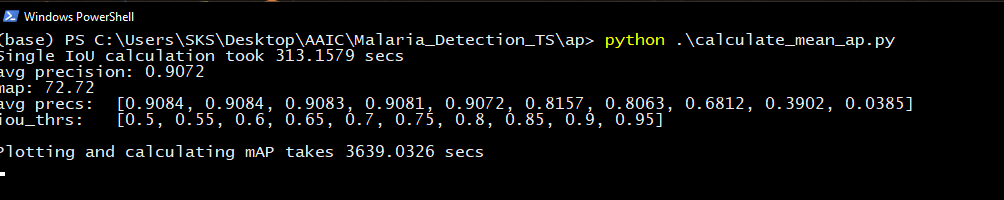

In [1]:
from IPython.display import Image
Image(filename='train_map_scores.png')

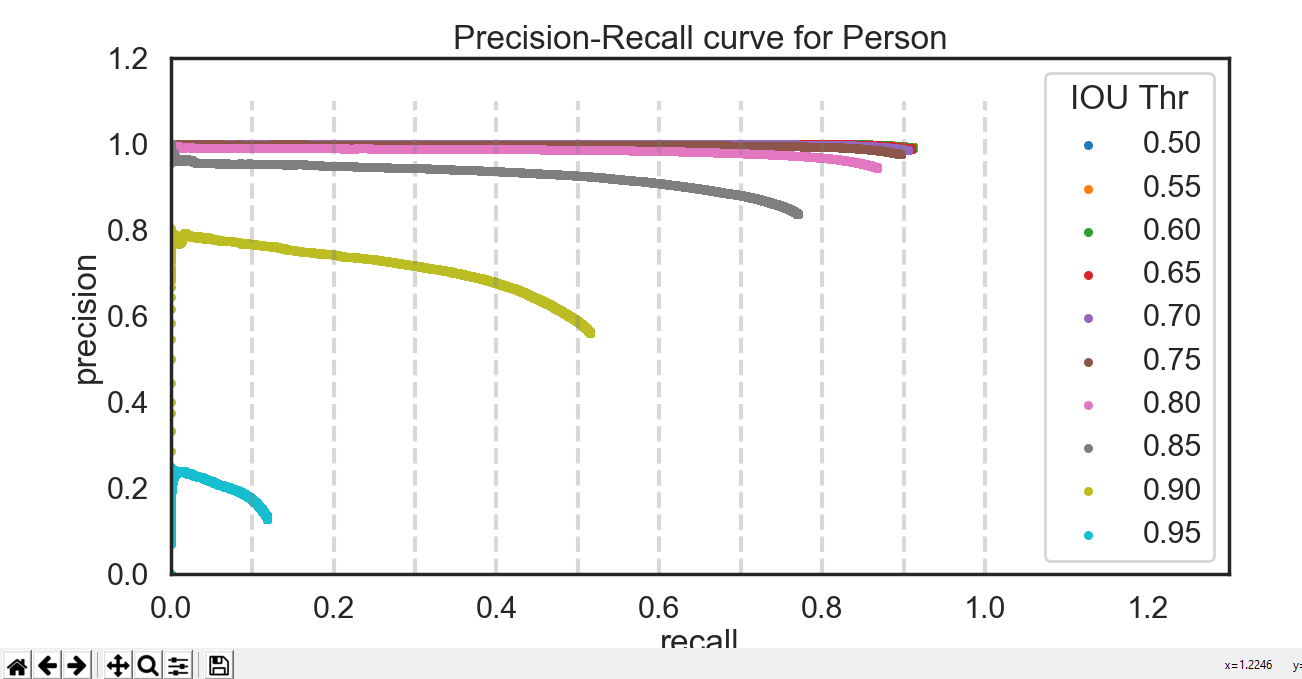

In [2]:
from IPython.display import Image
Image(filename='train_map_graph.png')

## Ground Truth and Prediction for F-RCNN 

In [21]:
df_train_two.label.value_counts()

red blood cell    77420
non_rbc            2252
Name: label, dtype: int64

In [22]:
train_prediction_rnn

{'red blood cell': 71040, 'non_rbc': 2246}

## Ground Truth and Prediction for VGG-16 with F-RCNN

In [23]:
df_train_all.label.value_counts()

red blood cell    77420
trophozoite        1473
ring                353
schizont            179
gametocyte          144
leukocyte           103
Name: label, dtype: int64

In [24]:
training_predicition_vgg

{'red blood cell': 71040,
 'schizont': 178,
 'ring': 311,
 'trophozoite': 1513,
 'gametocyte': 157,
 'leukocyte': 87}

## Prediction on Testing Data using Fine-tuned VGG-16

In [19]:
from tqdm import tqdm
import json
test=pd.read_json ('test.json')

In [20]:
data=[]
for i in tqdm(range(test.shape[0])):
    for j in range(len(test.iloc[i,1])):
        img_name=test.iloc[i,0]['pathname'].split('/')[2]
        label=test.iloc[i,1][j]['category']
        x_min=test.iloc[i,1][j]['bounding_box']['minimum']['c']
        x_max=test.iloc[i,1][j]['bounding_box']['maximum']['c']
        y_min=test.iloc[i,1][j]['bounding_box']['minimum']['r']
        y_max=test.iloc[i,1][j]['bounding_box']['maximum']['r']
        
        data.append([img_name,label,x_min,y_min,x_max,y_max])
df_test=pd.DataFrame(data,columns=['img_name','label','x_min','y_min','x_max','y_max'])   
for i in tqdm(range(5922)):
    if df_test.iloc[i,1] in non_rbc:
        df_test.iloc[i,1]='non_rbc'
df_test.img_name=df_test.img_name.apply(lambda x: "testing_images/"+str(x))
df_test_two=df_test[df_test['label']!="difficult"]

100%|███████████████████████████████████████████████████████████████████████████| 5922/5922 [00:00<00:00, 10565.53it/s]


In [21]:
test=pd.read_json ('test.json')
data=[]
for i in tqdm(range(test.shape[0])):
    for j in range(len(test.iloc[i,1])):
        img_name=test.iloc[i,0]['pathname'].split('/')[2]
        label=test.iloc[i,1][j]['category']
        x_min=test.iloc[i,1][j]['bounding_box']['minimum']['c']
        x_max=test.iloc[i,1][j]['bounding_box']['maximum']['c']
        y_min=test.iloc[i,1][j]['bounding_box']['minimum']['r']
        y_max=test.iloc[i,1][j]['bounding_box']['maximum']['r']
        
        data.append([img_name,label,x_min,y_min,x_max,y_max])
df_test=pd.DataFrame(data,columns=['img_name','label','x_min','y_min','x_max','y_max'])
df_test.img_name=df_test.img_name.apply(lambda x: "testing_images/"+str(x))
df_test_all=df_test[df_test['label']!="difficult"]

100%|███████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 298.56it/s]


In [22]:
testing_images=np.unique(df_test_two.img_name.values)
print(len(testing_images))

120


In [23]:
# loading the graph for faster r-cnn model 
from keras.models import load_model
lr_model= joblib.load('model_LR.pkl')  
from collections import defaultdict
model=tf.Graph()
with model.as_default():
    graphDef=tf.GraphDef()
    with tf.gfile.GFile("C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/experiments/exported_model/frozen_inference_graph.pb","rb") as f:
        serializedGraph=f.read()
        graphDef.ParseFromString(serializedGraph)
        tf.import_graph_def(graphDef,name="")
        
labelMap=label_map_util.load_labelmap(labels_loc)
categories=label_map_util.convert_label_map_to_categories(labelMap,max_num_classes=num_classes,use_display_name=True)
categoryIdx=label_map_util.create_category_index(categories)
classes=['gametocyte', 'leukocyte', 'ring', 'schizont', 'trophozoite']
testing_predicition_rnn={}
testing_predicition_vgg={}
predicted_boxes_stacked_test=defaultdict(dict)
with model.as_default():
    with tf.Session(graph=model) as sess:
        imageTensor=model.get_tensor_by_name("image_tensor:0")
        boxesTensor=model.get_tensor_by_name("detection_boxes:0")
        scoresTensor=model.get_tensor_by_name("detection_scores:0")
        classesTensor=model.get_tensor_by_name("detection_classes:0")
        numDetections=model.get_tensor_by_name("num_detections:0")
        with tf.Session() as sess2:
            vgg_model=VGG16(weights="imagenet", include_top=False)
            for img in tqdm(testing_images):
            # loading just 1 image for testing 
                image=cv2.imread(img)
                (H,W)= image.shape[:2]  

                output=image.copy()
                image=cv2.cvtColor(image.copy(),cv2.COLOR_BGR2RGB)
                image=np.expand_dims(image,axis=0)

                (boxes,scores,labels,N)= sess.run([boxesTensor,scoresTensor,classesTensor,numDetections],feed_dict={imageTensor:image})
                boxes=np.squeeze(boxes)
                scores=np.squeeze(scores)
                labels=np.squeeze(labels)
                o=[]
                boxes_nm=[]
                for (box,score,label) in zip(boxes,scores,labels):
                    if score<0.4:
                        continue
                    (startY,startX,endY,endX)=box
                    startX=int(startX*W)
                    startY=int(startY*H)
                    endX=int(endX*W)
                    endY=int(endY*H)
                    if img in predicted_boxes_stacked_test:
                        predicted_boxes_stacked_test[img]['boxes'].append([startX,startY,endX,endY])
                        predicted_boxes_stacked_test[img]['scores'].append(score)
                    else:
                        predicted_boxes_stacked_test[img]['boxes']=[[startX,startY,endX,endY]]
                        predicted_boxes_stacked_test[img]['scores']=[score]
                    if categoryIdx[label]['name']=="non_rbc":
                        if categoryIdx[label]['name'] in testing_predicition_rnn:
                            testing_predicition_rnn[categoryIdx[label]['name']]+=1
                        else:
                            testing_predicition_rnn[categoryIdx[label]['name']]=1
                        b_box=[startX,startY,endX,endY]
                        im=Image.open(img)
                        cr_img=im.crop(b_box)
                        cr_img=cr_img.resize((224,224))   
                        data=np.array(cr_img)
                        data=np.expand_dims(data,axis=0)
                        data=imagenet_utils.preprocess_input(data)
                        data=vgg_model.predict(data)
                        data=np.array(data)
                        data=data.reshape(1,512*7*7)
                        # Initialize model
                        pred = lr_model.predict(data)
                        label = classes[pred[0]]
                        if label in testing_predicition_vgg:
                            testing_predicition_vgg[label]+=1
                        else:
                            testing_predicition_vgg[label]=1
                    else:
                        label=categoryIdx[label]
                        idx=int(label["id"])-1
                        label=label['name']
                        if label in testing_predicition_rnn:
                            testing_predicition_rnn[label]+=1
                        else:
                            testing_predicition_rnn[label]=1
                        if label in testing_predicition_vgg:
                                testing_predicition_vgg[label]+=1
                        else:
                            testing_predicition_vgg[label]=1
with open('predicted_boxes_stacked_test.json', 'w') as fp:
    json.dump(str(predicted_boxes_stacked_test), fp)


Instructions for updating:
Colocations handled automatically by placer.


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [05:23<00:00,  2.70s/it]


## MAP Scores Test Data

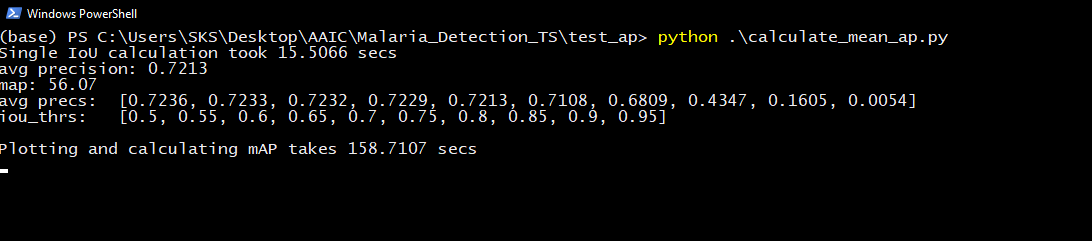

In [3]:
from IPython.display import Image
Image(filename='testing_map_scores.png')

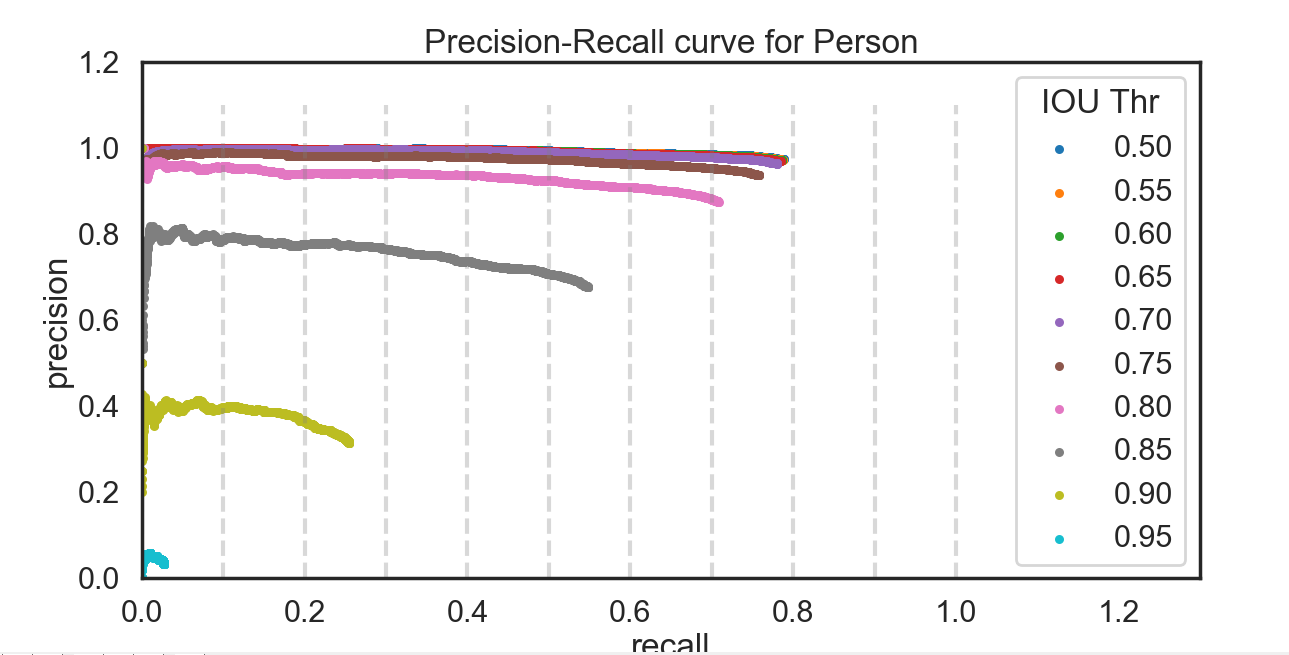

In [4]:
from IPython.display import Image
Image(filename='testing_map_plots.png')

## Ground Truth and prediction for F-RCNN

In [29]:
df_test_two.label.value_counts()

red blood cell    5614
non_rbc            303
Name: label, dtype: int64

In [30]:
testing_predicition_rnn

{'red blood cell': 4551, 'non_rbc': 244}

## Ground Truth and prediction for VGG-16 and LR with F-RCNN

In [31]:
df_test_all.label.value_counts()

red blood cell    5614
ring               169
trophozoite        111
gametocyte          12
schizont            11
Name: label, dtype: int64

In [32]:
testing_predicition_vgg

{'red blood cell': 4551,
 'trophozoite': 146,
 'ring': 95,
 'gametocyte': 7,
 'schizont': 6}

## Conclusion
* Architecture is same as the paper but the performance is not that good, requires more parameter tuning
* Faster R-CNN with VGG16 is working much better than Alexnet as all the non_rbc classes are predicting well while using the vgg16 as we are predicting very similar to ground_truth.
* while using alexnet the model is not working that well might need more hyperparameter tuning

